<a href="https://colab.research.google.com/github/yjay2kim/kai/blob/main/SINE_sample/kai_tf_SINE_sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow version: 2.9.2
/device:GPU:0


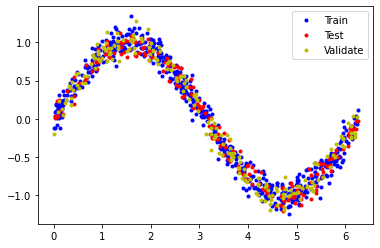

Epoch 1/500
10/10 [==============================] - 1s 45ms/step - loss: 0.6834 - mae: 0.7333 - val_loss: 0.5412 - val_mae: 0.6609
Epoch 2/500
10/10 [==============================] - 0s 7ms/step - loss: 0.4666 - mae: 0.6007 - val_loss: 0.4645 - val_mae: 0.5874
Epoch 3/500
10/10 [==============================] - 0s 7ms/step - loss: 0.4398 - mae: 0.5616 - val_loss: 0.4478 - val_mae: 0.5724
Epoch 4/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4226 - mae: 0.5469 - val_loss: 0.4266 - val_mae: 0.5610
Epoch 5/500
10/10 [==============================] - 0s 6ms/step - loss: 0.4011 - mae: 0.5373 - val_loss: 0.4085 - val_mae: 0.5519
Epoch 6/500
10/10 [==============================] - 0s 7ms/step - loss: 0.3841 - mae: 0.5304 - val_loss: 0.3925 - val_mae: 0.5430
Epoch 7/500
10/10 [==============================] - 0s 6ms/step - loss: 0.3680 - mae: 0.5197 - val_loss: 0.3759 - val_mae: 0.5318
Epoch 8/500
10/10 [==============================] - 0s 7ms/step - loss: 0.3520 - 

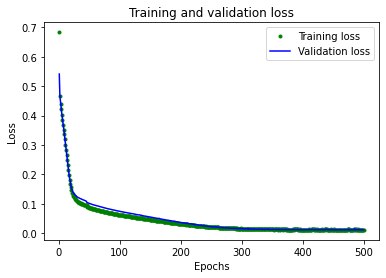

7/7 [==============================] - 0s 2ms/step


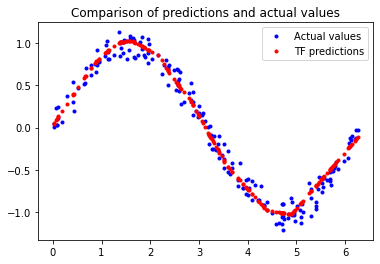

7/7 [==============================] - 0s 2ms/step


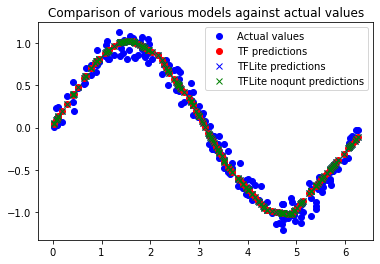

4096 3188


In [38]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import os

def generate_random_data():
  seed = 1
  np.random.seed(seed)
  tf.random.set_seed(seed)

  # Set x range and get sine(x)
  SAMPLES = 1000
  x_values = np.random.uniform(low=0, high=2*math.pi, size=SAMPLES).astype(np.float32)
  np.random.shuffle(x_values)
  y_values = np.sin(x_values).astype(np.float32)
  
  # Add Noise
  y_values += 0.1 * np.random.randn(*y_values.shape)

  # Split data into Training, Validation, Testing
  TRAIN_SPLIT = int(0.6 * SAMPLES)
  TEST_SPLIT = int(0.2 * SAMPLES + TRAIN_SPLIT)
  x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
  y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])
  assert (x_train.size + x_validate.size + x_test.size) ==  SAMPLES

  # Draw dataset
  plt.plot(x_train, y_train, 'b.', label="Train")
  plt.plot(x_test, y_test, 'r.', label="Test")
  plt.plot(x_validate, y_validate, 'y.', label="Validate")
  plt.legend()
  plt.show()

  return x_train, x_test, x_validate, y_train, y_test, y_validate


def predict_tflite(tflite_model, x_test):
  # Prepare the test data
  x_test_ = x_test.copy()
  x_test_ = x_test_.reshape((x_test.size, 1))
  x_test_ = x_test_.astype(np.float32)

  # Initialize the TFLite interpreter
  interpreter = tf.lite.Interpreter(model_content=tflite_model,
                                    experimental_op_resolver_type=tf.lite.experimental.OpResolverType.BUILTIN_REF)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  # Invoke the interpreter
  y_pred = np.empty(x_test_.size, dtype=output_details["dtype"])
  for i in range(len(x_test_)):
    interpreter.set_tensor(input_details["index"], [x_test_[i]])
    interpreter.invoke()
    y_pred[i] = interpreter.get_tensor(output_details["index"])[0]

  return y_pred

def evaluate_tflite(tflite_model, x_test, y_true):
  global model
  y_pred = predict_tflite(tflite_model, x_test)
  loss_function = tf.keras.losses.get(model.loss)
  loss = loss_function(y_true, y_pred).numpy()
  return loss

# 0. Check environment
print("TensorFlow version:", tf.__version__)
print (tf.test.gpu_device_name())

# 1. Getting sample data
x_train, x_test, x_validate, y_train, y_test, y_validate = generate_random_data()

# 2. Design the model
model = tf.keras.Sequential()                                               # Architecture == Sequential
model.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(1,)))   # Use 8 neurons, relu, data frame has 1 column
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))                                         # Use 1 neurons for final layer == single value output

model.compile(optimizer='adam',                                             # Optimized model with opti = How to find minimal loss
              loss='mse',                                                   # loss = What is loss
              metrics=['mae'])                                              # metrics = How to evaluate


# 3. Train the model
history = model.fit(x_train, y_train, epochs=500, batch_size=64,
                    validation_data=(x_validate, y_validate))

# 4. Draw metrics
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 5. Compare prediction and actual data
test_loss, test_mae = model.evaluate(x_test, y_test)                 # Calculate and print the loss on our test dataset
y_test_pred = model.predict(x_test)                                  # Make predictions based on our test dataset

plt.clf()                                                            # Graph the predictions against the actual values
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

# 6. Export the TF model
tf.saved_model.save(model, "/content/kai_sine_sample_model")

# 6. Convert to TensorFlow Lite Model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/kai_sine_sample_model")
model_no_quant_tflite = converter.convert()
open("/content/kai_sine_sample_model/model.tflite", "wb").write(model_no_quant_tflite)

# 7. Get prediction from tflite model
y_test_pred_tf = model.predict(x_test)
y_test_pred_no_quant_tflite = predict_tflite(model_no_quant_tflite, x_test)
y_test_pred_tflite = predict_tflite(model_no_quant_tflite, x_test)

plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(x_test, y_test, 'bo', label='Actual values')
plt.plot(x_test, y_test_pred_tf, 'ro', label='TF predictions')
plt.plot(x_test, y_test_pred_no_quant_tflite, 'bx', label='TFLite predictions')
plt.plot(x_test, y_test_pred_tflite, 'gx', label='TFLite noqunt predictions')
plt.legend()
plt.show()

# 8. Print statistics 
size_tf = os.path.getsize("/content/kai_sine_sample_model")
size_no_quant_tflite = os.path.getsize("/content/kai_sine_sample_model/model.tflite")
print (size_tf, size_no_quant_tflite)

